## Load Dependancies

In [1]:
project_name = 'dhcp'
import os
#get current working directory
cwd = os.getcwd()
git_dir = cwd.split(project_name)[0] + project_name
import sys

#add git_dir to path
sys.path.append(git_dir)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dhcp_params as params

from sklearn.manifold import MDS
import pdb
#from d3blocks import D3Blocks
#d3 = D3Blocks()

import warnings
warnings.filterwarnings('ignore')

from d3blocks import D3Blocks
# Initialize
d3 = D3Blocks()



[d3blocks] >INFO> Cleaning edge_properties and config parameters..


In [2]:
atlas = 'wang'


#load atlast name and roi labels
#atlas_name, roi_labels = params.load_atlas_info(atlas)
atlas_info = params.load_atlas_info(atlas)

atlas_name, roi_labels = atlas_info.atlas_name, atlas_info.roi_labels

age_groups = ['infant', 'adult']

atlas = 'wang'

infant_params = params.load_group_params('infant')
adult_params = params.load_group_params('adult')

#color code rois by network
#inds 1-7 are EVC
#inds 8-11 are ventral
#inds 12-17 are lateral
#inds 18-25 are dorsal

#add networks to roi labels
#roi_labels['network'] = ['EVC']*6 + ['ventral']*5 + ['lateral']*6 + ['dorsal']*7

networks = ['Occipital', 'Ventral', 'Lateral', 'Dorsal']
network_colors = ['#fd0000', '#be00fd', '#1105d8', 'green']

#expand roi labels to include hemis
all_rois = []
all_networks = []



all_rois = []
all_networks = []
for roi in roi_labels['label']:
    for hemi in params.hemis:
        all_rois.append(f'{hemi}_{roi}')
        all_networks.append(roi_labels[roi_labels['label'] == roi]['network'].values[0])


age_bins = [26,33, 38,42,46]
age_groups = ['pre','early','term','post']

#### Visualization functions

In [3]:
def plot_fc_matrix(corr_mat, roi_labels, file_name):
    #make diagonal to nans
    corr_mat = np.array(corr_mat)
    print(corr_mat.shape)
    #corr_mat = np.fill_diagonal(corr_mat, np.nan)

    #extract upper triangle
    #corr_mat = np.triu(corr_mat)


    sns.heatmap(corr_mat, cmap= 'viridis', cbar =False)
    #make bigger 
    plt.gcf().set_size_inches(5,5)

    
    

    #make background black
    ax = plt.gca()

    #make plot square
    ax.set_aspect('equal', 'box')

    #tight layout
    plt.tight_layout()

    

    if file_name is not None:
        #plt.savefig(f'{git_dir}/figures/{file_name}_with_labels.png')    

        #remove labels
        plt.xticks([])
        plt.yticks([])
        plt.savefig(f'{git_dir}/figures/{file_name}.png', bbox_inches = 'tight', dpi = 300)

    #add labels from all_labels
    #plt.xticks(np.arange(0.5, len(roi_labels), 1), roi_labels, rotation = 90)
    #plt.yticks(np.arange(0.5, len(roi_labels), 1), roi_labels, rotation = 0)

    plt.show()
    plt.pause(.001)



In [4]:
def create_mat(df,col = 'fc',all_rois = all_rois):
    #create empty matrix to store infant data
    mat = np.zeros((len(all_rois), len(all_rois)))

    #fill in infant matrix with infant data
    for i, roi1 in enumerate(all_rois):
        for j, roi2 in enumerate(all_rois):
            if roi1 == roi2:
                mat[i,j] = 1
            else:
                mat[i,j] = df[(df['roi1'] == roi1) & (df['roi2'] == roi2)][col].values[0]

    return mat

In [5]:
def plot_mds(fc_mat,  all_rois, all_networks, seed=None, file_name=None):


    #set diagonal to 1
    np.fill_diagonal(fc_mat, 1)

    #check if all_networks is a list of strings or ints
    if isinstance(all_networks[0], str):
        net_type = 'str'
    elif isinstance(all_networks[0], int):
        net_type = 'int'

    z_val = 1
    #run MDS on fc matrix
    mds = MDS(n_components = 2, dissimilarity = 'euclidean', random_state = seed)
    mds_results = mds.fit(fc_mat).embedding_

    #plot the edges between rois
    for i in range(len(all_rois)):
        for j in range(len(all_rois)):
            #convert fc_mat to value between min and max
            connection_strength = (fc_mat[i,j] - np.min(fc_mat)) / (np.max(fc_mat) - np.min(fc_mat))

            #set linewidth to be between .1 and 3
            linewidth = .001 + connection_strength * 2.9

            #rescale opacity vals
            opacity_val = .0001 + connection_strength * .15

        
            plt.plot([mds_results[i,0], mds_results[j,0]], [mds_results[i,1], mds_results[j,1]], c = 'k', alpha = opacity_val, linewidth = linewidth, zorder = z_val)
            z_val += 1


    for i, net_id in enumerate(all_networks):
        #if net_id is a string or int
        if net_type == 'str':
            plt.scatter(mds_results[i,0], mds_results[i,1], c = network_colors[networks.index(net_id)], label = net_id, s =50, edgecolors = 'k', zorder = z_val)
        elif net_type == 'int':
            plt.scatter(mds_results[i,0], mds_results[i,1], c = network_colors[net_id], label = net_id, s =50, edgecolors = 'k', zorder = z_val)
        


        
        z_val += 1


    #color code points by network and network_color
    for i, net in enumerate(networks):
        plt.scatter(mds_results[networks==net,0], mds_results[networks==net,1], c = network_colors[i], label = net, zorder = z_val, s = 50)
        z_val += 1

    #add labels
    for i, label in enumerate(all_rois):
        #replace lh_ and rh_ with l and r
        label = label.replace('lh_', 'l')
        label = label.replace('rh_', 'r')
        

        if net_type == 'str':

            #add text each point, with the label, with background color
            plt.text(mds_results[i,0]+.025, mds_results[i,1]+.025, label, fontsize = 10, zorder = z_val, color = 'white', bbox=dict(facecolor=network_colors[networks.index(all_networks[i])], alpha=0.7))

        elif net_type == 'int':
            plt.text(mds_results[i,0]+.025, mds_results[i,1]+.025, label, fontsize = 10, zorder = z_val, color = 'white', bbox=dict(facecolor=network_colors[all_networks[i]], alpha=0.7))
            


        #plt.annotate(label, (mds_results[i,0], mds_results[i,1]), zorder = z_val)
        #add box around label
        
        z_val += 1

    #make plot larger
    

    #remove ticks
    plt.xticks([])
    plt.yticks([])

    #remove axis
    plt.axis('off')

    #tight layout
    plt.tight_layout()


    #if file_name is not None:
    if file_name is not None:
        plt.rcParams['figure.figsize'] = [4, 4]
    
        
        #save plot
        plt.savefig(f'{git_dir}/figures/{file_name}.png')
    else:
        plt.rcParams['figure.figsize'] = [5, 5]

    
    plt.show()
    plt.pause(.001)


In [6]:


#load infant data
infant_df = pd.read_csv(f'{infant_params.out_dir}/derivatives/{atlas}/infant_{atlas}_roi_similarity.csv')

#add age column by subtracting scan_age from birth_age
infant_df['age'] = (infant_df['scan_age'] - infant_df['birth_age'])*7
for i in range(len(age_bins)-1):
    infant_df.loc[(infant_df['scan_age'] >= age_bins[i]) & (infant_df['scan_age'] < age_bins[i+1]), 'age_group'] = age_groups[i]


adult_df = pd.read_csv(f'{adult_params.out_dir}/derivatives/{atlas}/adult_{atlas}_roi_similarity.csv')


#### MDS for infants on day 1

In [9]:
# extract infants that were scanned on day 1
curr_df = infant_df[(infant_df['age'] <= 1) & (infant_df['age_group'] == 'term') | (infant_df['age'] <= 1) & (infant_df['age_group'] == 'post')]

'''Compute mat for both hemis'''
curr_df_mean = curr_df.groupby(by=['hemi1', 'roi1', 'hemi2','roi2']).median(numeric_only=True).reset_index()
#concat hemi and roi columns to create roi labels
curr_df_mean['roi1'] = curr_df_mean['hemi1'] + '_' + curr_df_mean['roi1']
curr_df_mean['roi2'] = curr_df_mean['hemi2'] + '_' + curr_df_mean['roi2']

#extract fc matrix
fc_mat = create_mat(curr_df_mean, col = 'fc')
#convert to pandas df
fc_mat_df = pd.DataFrame(fc_mat, columns = all_rois, index = all_rois)
#save
fc_mat_df.to_csv(f'{git_dir}/results/fc_mat/infant_day1_{atlas}_fc_mat.csv')

'''Compute mat for across hemis'''
# extract infants that were scanned on day 1
curr_df = infant_df[(infant_df['age'] <= 1) & (infant_df['age_group'] == 'term') | (infant_df['age'] <= 1) & (infant_df['age_group'] == 'post')]
#extract data where hemi_similarity is diff
curr_df = curr_df[curr_df['hemi_similarity'] == 'diff']

curr_df_mean = curr_df.groupby(by=['roi1', 'roi2']).median(numeric_only=True).reset_index()
#concat hemi and roi columns to create roi labels
#curr_df_mean['roi1'] = curr_df_mean['hemi1'] + '_' + curr_df_mean['roi1']
#curr_df_mean['roi2'] = curr_df_mean['hemi2'] + '_' + curr_df_mean['roi2']

#extract fc matrix
fc_mat = create_mat(curr_df_mean, col = 'fc', all_rois = roi_labels['label'].tolist())
#convert to pandas df
fc_mat_df = pd.DataFrame(fc_mat, columns = roi_labels['label'], index = roi_labels['label'])
#save
fc_mat_df.to_csv(f'{git_dir}/results/fc_mat/infant_day1_{atlas}_fc_mat_across_hemi.csv')


NameError: name 'infant_df' is not defined

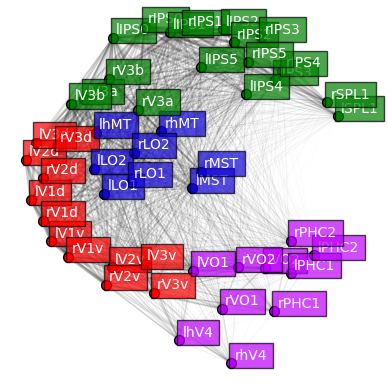

(48, 48)


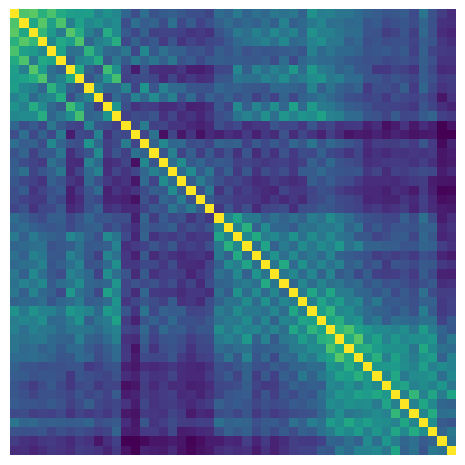

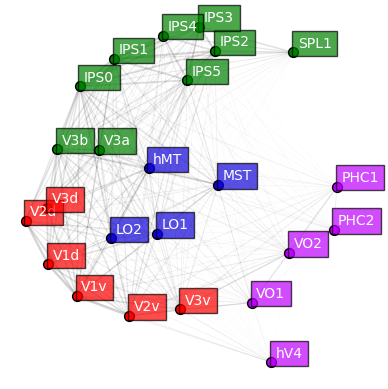

In [9]:
#load data and make mds
fc_mat = pd.read_csv(f'{git_dir}/results/fc_mat/infant_day1_{atlas}_fc_mat.csv', index_col = 0).values

'''Plot both hemi data'''
plot_mds(fc_mat, all_rois, all_networks, seed = 40, file_name = f'infant_day1_{atlas}_mds')

'''plot fc matrix'''
plot_fc_matrix(fc_mat, all_rois, file_name = f'infant_day1_{atlas}_fc_mat')


'''Plot across-hemi data'''
fc_mat = pd.read_csv(f'{git_dir}/results/fc_mat/infant_day1_{atlas}_fc_mat_across_hemi.csv', index_col = 0).values

plot_mds(fc_mat, roi_labels['label'].tolist(), roi_labels['network'].tolist(), seed = 20, file_name = f'infant_day1_{atlas}_mds_across_hemi')




#### MDS for adults

In [10]:
'''
Comptue fc_mats for adult data
'''

#load adult_df
adult_df = pd.read_csv(f'{adult_params.out_dir}/derivatives/{atlas}/adult_{atlas}_roi_similarity.csv')

'''Compute mat for both hemis'''
curr_df_mean = adult_df.groupby(by=['hemi1', 'roi1', 'hemi2','roi2']).median(numeric_only=True).reset_index()
#concat hemi and roi columns to create roi labels
curr_df_mean['roi1'] = curr_df_mean['hemi1'] + '_' + curr_df_mean['roi1']
curr_df_mean['roi2'] = curr_df_mean['hemi2'] + '_' + curr_df_mean['roi2']

#extract fc matrix
fc_mat = create_mat(curr_df_mean, col = 'fc')
#convert to pandas df
fc_mat_df = pd.DataFrame(fc_mat, columns = all_rois, index = all_rois)
#save
fc_mat_df.to_csv(f'{git_dir}/results/fc_mat/adult_{atlas}_fc_mat.csv')

In [11]:
'''
Comptue fc_mats for adult data
'''


'''Compute mat for both hemis'''
curr_df_mean = adult_df.groupby(by=['hemi1', 'roi1', 'hemi2','roi2']).median(numeric_only=True).reset_index()
#concat hemi and roi columns to create roi labels
curr_df_mean['roi1'] = curr_df_mean['hemi1'] + '_' + curr_df_mean['roi1']
curr_df_mean['roi2'] = curr_df_mean['hemi2'] + '_' + curr_df_mean['roi2']

#extract fc matrix
fc_mat = create_mat(curr_df_mean, col = 'fc')
#convert to pandas df
fc_mat_df = pd.DataFrame(fc_mat, columns = all_rois, index = all_rois)
#save
fc_mat_df.to_csv(f'{git_dir}/results/fc_mat/adult_{atlas}_fc_mat.csv')

'''Compute mat for across hemis'''
# extract infants that were scanned on day 1

#extract data where hemi_similarity is diff
curr_df = adult_df[adult_df['hemi_similarity'] == 'diff']

curr_df_mean = curr_df.groupby(by=['roi1', 'roi2']).median(numeric_only=True).reset_index()
#concat hemi and roi columns to create roi labels
#curr_df_mean['roi1'] = curr_df_mean['hemi1'] + '_' + curr_df_mean['roi1']
#curr_df_mean['roi2'] = curr_df_mean['hemi2'] + '_' + curr_df_mean['roi2']

#extract fc matrix
fc_mat = create_mat(curr_df_mean, col = 'fc', all_rois = roi_labels['label'].tolist())
#convert to pandas df
fc_mat_df = pd.DataFrame(fc_mat, columns = roi_labels['label'], index = roi_labels['label'])
#save
fc_mat_df.to_csv(f'{git_dir}/results/fc_mat/adult_{atlas}_fc_mat_across_hemi.csv')

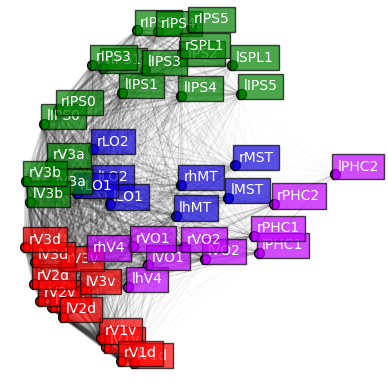

(48, 48)


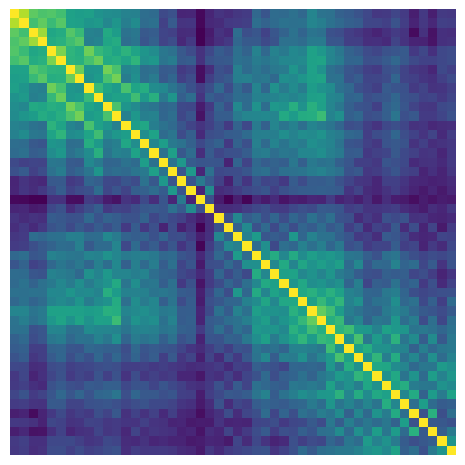

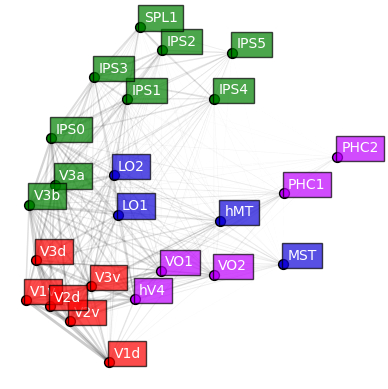

In [12]:

'''both hemi mds'''
adult_fc_mat = pd.read_csv(f'{git_dir}/results/fc_mat/adult_{atlas}_fc_mat.csv', index_col = 0).values
#adult_fc_mat = adult_fc_mat[12:,12:]

plot_mds(adult_fc_mat, all_rois, all_networks, seed = 4, file_name = f'adult_{atlas}_mds')

'''plot fc matrix'''
plot_fc_matrix(adult_fc_mat, all_rois, file_name = f'adult_{atlas}_fc_mat')


'''across hemi mds'''
adult_fc_mat = pd.read_csv(f'{git_dir}/results/fc_mat/adult_{atlas}_fc_mat_across_hemi.csv', index_col = 0).values

plot_mds(adult_fc_mat, roi_labels['label'].tolist(), roi_labels['network'].tolist(), seed = 7, file_name = f'adult_{atlas}_mds_across_hemi')

In [28]:
'''correlate infant and adult fc matrices'''

infant_fc = pd.read_csv(f'{git_dir}/results/fc_mat/infant_day1_{atlas}_fc_mat.csv', index_col = 0).values
adult_fc = pd.read_csv(f'{git_dir}/results/fc_mat/adult_{atlas}_fc_mat.csv', index_col = 0).values

#extract upper triangle of each, excluding diagonal
infant_fc = np.triu(infant_fc, k = 1)
adult_fc = np.triu(adult_fc, k = 1)


#flatten
infant_fc = infant_fc.flatten()
adult_fc = adult_fc.flatten()

#correlate
np.corrcoef(infant_fc, adult_fc)


array([[1.        , 0.95770644],
       [0.95770644, 1.        ]])

plot_mds(fc_mat, all_rois, infant_clustering.labels_, seed = 14, file_name = f'infant_{atlas}_mds_day1')

#### MDS for infants at different points of gestation

In [7]:
age_bins = [26,33, 38,42,46]
age_groups = ['pre','early','term','post']

#create mats for each age group
for i in range(len(age_bins)-1):
    curr_df = infant_df[(infant_df['scan_age'] >= age_bins[i]) & (infant_df['scan_age'] < age_bins[i+1])]
    curr_df_mean = curr_df.groupby(by=['hemi1', 'roi1', 'hemi2','roi2']).median(numeric_only=True).reset_index()
    #concat hemi and roi columns to create roi labels
    curr_df_mean['roi1'] = curr_df_mean['hemi1'] + '_' + curr_df_mean['roi1']
    curr_df_mean['roi2'] = curr_df_mean['hemi2'] + '_' + curr_df_mean['roi2']

    #extract fc matrix
    fc_mat = create_mat(curr_df_mean, col = 'fc')
    #convert to pandas df
    fc_mat_df = pd.DataFrame(fc_mat, columns = all_rois, index = all_rois)
    #save
    fc_mat_df.to_csv(f'{git_dir}/results/infant_{atlas}_fc_mat_{age_groups[i]}.csv')

pre


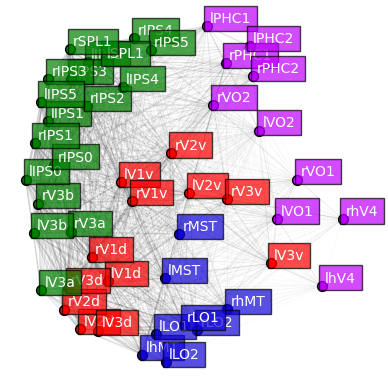

early


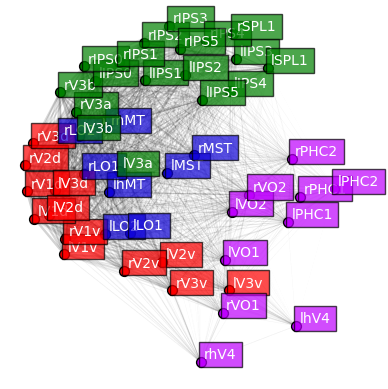

term


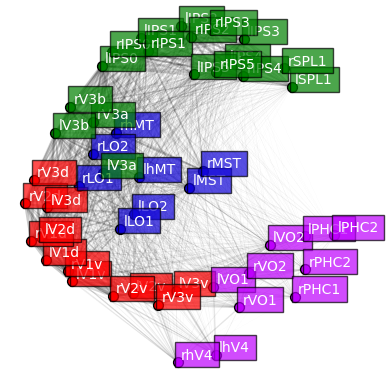

post


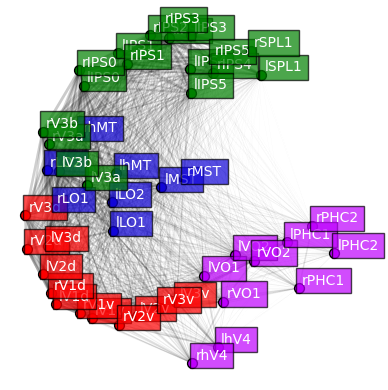

In [12]:
age_groups = ['pre','early','term','post']
seeds =[24,4,40,40]

for i, age_group in enumerate(age_groups):
    print(age_group)
    #load data and make mds
    fc_mat_df = pd.read_csv(f'{git_dir}/results/infant_{atlas}_fc_mat_{age_group}.csv', index_col = 0).values

    plot_mds(fc_mat_df, all_rois, all_networks, seed = seeds[i], file_name = f'infant_{atlas}_mds_{age_group}')


## Create Chord plots

In [42]:
def create_chord_plot_roi(df,filename=None):
    d3 = D3Blocks(chart='Chord', frame=False)

    d3.chord(df, opacity=df['weight'])


    #loop through rois and assign color
    for i, roi in enumerate(df['source']):
        d3.node_properties.get(roi)['color']=df['color'][i]

        d3.edge_properties.loc[d3.edge_properties['source'] == roi,'color'] = df['color'][i]


    d3.show(filepath = f'{git_dir}/figures/chord/{filename}.html')

In [84]:
def create_chord_plot_network(df,filename=None):
    d3 = D3Blocks(chart='Chord', frame=False)

    d3.chord(df, opacity=df['weight'])


    #loop through rois and assign color
    for i, roi in enumerate(df['source']):
        
        d3.node_properties.get(roi)['color']=df['color'][i]

        #do same for opacity
        #d3.node_properties.get(roi)['opacity']=df['opacity'][i]
        d3.edge_properties.loc[d3.edge_properties['source'] == roi,'color'] = df['color'][i]

        for i, roi in enumerate(df['target']):
            #set opacity for source target pair
            d3.edge_properties.loc[(d3.edge_properties['source'] == df['source'][i]) & (d3.edge_properties['target'] == df['target'][i]),'opacity'] = df['opacity'][i]


    d3.show(filepath = f'{git_dir}/figures/chord/{filename}.html')

In [44]:

#load infant data
infant_df = pd.read_csv(f'{infant_params.out_dir}/derivatives/{atlas}/infant_{atlas}_roi_similarity.csv')

#add age column by subtracting scan_age from birth_age
infant_df['age'] = (infant_df['scan_age'] - infant_df['birth_age'])*7
for i in range(len(age_bins)-1):
    infant_df.loc[(infant_df['scan_age'] >= age_bins[i]) & (infant_df['scan_age'] < age_bins[i+1]), 'age_group'] = age_groups[i]


adult_df = pd.read_csv(f'{adult_params.out_dir}/derivatives/{atlas}/adult_{atlas}_roi_similarity.csv')


In [105]:
'''
Correlation between all ROIs
'''

# extract infants that were scanned on day 1
curr_df = infant_df[(infant_df['age'] <= 1) & (infant_df['age_group'] == 'term') | (infant_df['age'] <= 1) & (infant_df['age_group'] == 'post')]

'''Compute mat for both hemis'''
curr_df_mean = curr_df.groupby(by=['hemi1','network1', 'roi1', 'hemi2','network2','roi2']).median(numeric_only=True).reset_index()
curr_df_mean['fc'] = (curr_df_mean['fc'] - np.min(curr_df_mean['fc'])) / (np.max(curr_df_mean['fc']) - np.min(curr_df_mean['fc']))
#concat hemi and roi columns to create roi labels
curr_df_mean['roi1'] = curr_df_mean['hemi1'] + '_' + curr_df_mean['roi1']
curr_df_mean['roi2'] = curr_df_mean['hemi2'] + '_' + curr_df_mean['roi2']

#rename roi1 to source and roi2 to target
curr_df_mean = curr_df_mean.rename(columns = {'roi1':'source', 'roi2':'target'})

#split columns by _
curr_df_mean[['hemi', 'source']] = curr_df_mean['source'].str.split('_', expand = True)
curr_df_mean[['hemi', 'target']] = curr_df_mean['target'].str.split('_', expand = True)

#drop rows with same roi
curr_df_mean = curr_df_mean[curr_df_mean['source'] != curr_df_mean['target']]

df = curr_df_mean.groupby(['source', 'target','network1']).mean(numeric_only=True).reset_index()

#rename fc to weight
df = df.rename(columns = {'fc':'weight'})

for roi in roi_labels['label']:
    df.loc[df['source'] == roi, 'source'] = f'{roi_labels[roi_labels["label"] == roi]["index"].values[0]:03d}_{roi}'
    df.loc[df['target'] == roi, 'target'] = f'{roi_labels[roi_labels["label"] == roi]["index"].values[0]:03d}_{roi}'



df['color'] = df['network1'].map({'Occipital':network_colors[0], 'Ventral':network_colors[1], 'Lateral':network_colors[2], 'Dorsal':network_colors[3]})

#exponentiate opacity
df['opacity'] = np.exp(df['weight'])

#add opacity column that equals weight
df['opacity'] = df['weight']

#scale opacity as a proportion of max fc
df['opacity'] = df['opacity'] / np.max(df['opacity'])


create_chord_plot_roi(df,'infant_day1_connectivity_roi')


[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Set edge-opacity to default value (0.8).
[d3blocks] >INFO> Set edge-colors based on the [source] node-color.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> File already exists and will be overwritten: [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Open browser: /tmp/d3blocks/chord.html
[d3blocks] >INFO> Set [filepath]: /mnt/DataDrive3/vlad/git_repos/dhcp/figures/chord/infant_day1_connectivity_roi.html
[d3blocks] >INFO> File already exists and will be overwritten: [/mnt/DataDrive3/vlad/git_repos/dhcp/figures/chord/infant_day1_connectivity_roi.html]
[d3blocks] >INFO> Open browser: /

In [101]:
'''group by network'''

curr_df = infant_df[(infant_df['age'] <= 1) & (infant_df['age_group'] == 'term') | (infant_df['age'] <= 1) & (infant_df['age_group'] == 'post')]
curr_df_mean = curr_df.groupby(by=['network1','network2']).median(numeric_only=True).reset_index()

#first group by roi
curr_df_mean = curr_df.groupby(by=['hemi1','network1', 'roi1', 'hemi2','network2','roi2']).median(numeric_only=True).reset_index()


#scale fc values to be between 0 and 1
curr_df_mean['fc'] = (curr_df_mean['fc'] - np.min(curr_df_mean['fc'])) / (np.max(curr_df_mean['fc']) - np.min(curr_df_mean['fc']))
curr_df_mean = curr_df_mean.groupby(by=['network1','network2']).median(numeric_only=True).reset_index()

#rename roi1 to source and roi2 to target
curr_df_mean = curr_df_mean.rename(columns = {'network1':'source', 'network2':'target'})
#drop rows with same roi
df = curr_df_mean[curr_df_mean['source'] != curr_df_mean['target']]
#rename fc to weight
df = df.rename(columns = {'fc':'weight'})


df['color'] = df['source'].map({'Occipital':network_colors[0], 'Ventral':network_colors[1], 'Lateral':network_colors[2], 'Dorsal':network_colors[3]})
for n, network in enumerate(networks):
    print(f'{n}_{network}')
    df.loc[df['source'] == network, 'source'] = f'{n}_{network}'
    df.loc[df['target'] == network, 'target'] = f'{n}_{network}'

#exponentiate opacity
df['opacity'] = np.exp(df['weight'])

#add opacity column that equals weight
df['opacity'] = df['weight']

#scale opacity as a proportion of max fc
df['opacity'] = df['opacity'] / np.max(df['opacity'])

#reset index
df = df.reset_index(drop=True)
create_chord_plot_network(df,'infant_day1_network')

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Set edge-opacity to default value (0.8).
[d3blocks] >INFO> Set edge-colors based on the [source] node-color.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> File already exists and will be overwritten: [/tmp/d3blocks/chord.html]


0_Occipital
1_Ventral
2_Lateral
3_Dorsal


[d3blocks] >INFO> Open browser: /tmp/d3blocks/chord.html
[d3blocks] >INFO> Set [filepath]: /mnt/DataDrive3/vlad/git_repos/dhcp/figures/chord/infant_day1_network.html
[d3blocks] >INFO> File already exists and will be overwritten: [/mnt/DataDrive3/vlad/git_repos/dhcp/figures/chord/infant_day1_network.html]
[d3blocks] >INFO> Open browser: /mnt/DataDrive3/vlad/git_repos/dhcp/figures/chord/infant_day1_network.html


In [106]:
'''
Correlation between all ROIs
'''

# extract infants that were scanned on day 1
#curr_df = infant_df[(infant_df['age'] <= 1) & (infant_df['age_group'] == 'term') | (infant_df['age'] <= 1) & (infant_df['age_group'] == 'post')]

'''Compute mat for both hemis'''
curr_df_mean = adult_df.groupby(by=['hemi1','network1', 'roi1', 'hemi2','network2','roi2']).median(numeric_only=True).reset_index()
curr_df_mean['fc'] = (curr_df_mean['fc'] - np.min(curr_df_mean['fc'])) / (np.max(curr_df_mean['fc']) - np.min(curr_df_mean['fc']))
#concat hemi and roi columns to create roi labels
curr_df_mean['roi1'] = curr_df_mean['hemi1'] + '_' + curr_df_mean['roi1']
curr_df_mean['roi2'] = curr_df_mean['hemi2'] + '_' + curr_df_mean['roi2']

#rename roi1 to source and roi2 to target
curr_df_mean = curr_df_mean.rename(columns = {'roi1':'source', 'roi2':'target'})

#split columns by _
curr_df_mean[['hemi', 'source']] = curr_df_mean['source'].str.split('_', expand = True)
curr_df_mean[['hemi', 'target']] = curr_df_mean['target'].str.split('_', expand = True)

#drop rows with same roi
curr_df_mean = curr_df_mean[curr_df_mean['source'] != curr_df_mean['target']]

df = curr_df_mean.groupby(['source', 'target','network1']).mean(numeric_only=True).reset_index()

#rename fc to weight
df = df.rename(columns = {'fc':'weight'})

for roi in roi_labels['label']:
    df.loc[df['source'] == roi, 'source'] = f'{roi_labels[roi_labels["label"] == roi]["index"].values[0]:03d}_{roi}'
    df.loc[df['target'] == roi, 'target'] = f'{roi_labels[roi_labels["label"] == roi]["index"].values[0]:03d}_{roi}'



df['color'] = df['network1'].map({'Occipital':network_colors[0], 'Ventral':network_colors[1], 'Lateral':network_colors[2], 'Dorsal':network_colors[3]})

#exponentiate opacity
df['opacity'] = np.exp(df['weight'])

#add opacity column that equals weight
df['opacity'] = df['weight']

#scale opacity as a proportion of max fc
df['opacity'] = df['opacity'] / np.max(df['opacity'])


create_chord_plot_roi(df,'adult_connectivity_roi')


[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Set edge-opacity to default value (0.8).
[d3blocks] >INFO> Set edge-colors based on the [source] node-color.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> File already exists and will be overwritten: [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Open browser: /tmp/d3blocks/chord.html
[d3blocks] >INFO> Set [filepath]: /mnt/DataDrive3/vlad/git_repos/dhcp/figures/chord/adult_connectivity_roi.html
[d3blocks] >INFO> File already exists and will be overwritten: [/mnt/DataDrive3/vlad/git_repos/dhcp/figures/chord/adult_connectivity_roi.html]
[d3blocks] >INFO> Open browser: /mnt/DataDriv

In [103]:
'''group by network adults'''
curr_df_mean = adult_df.groupby(by=['hemi1','network1', 'roi1', 'hemi2','network2','roi2']).median(numeric_only=True).reset_index()
#extract strongest correlation



curr_df_mean = curr_df_mean.groupby(by=['network1','network2']).median(numeric_only=True).reset_index()

#rename roi1 to source and roi2 to target
curr_df_mean = curr_df_mean.rename(columns = {'network1':'source', 'network2':'target'})
#drop rows with same roi
df = curr_df_mean[curr_df_mean['source'] != curr_df_mean['target']]
#rename fc to weight
df = df.rename(columns = {'fc':'weight'})


df['color'] = df['source'].map({'Occipital':network_colors[0], 'Ventral':network_colors[1], 'Lateral':network_colors[2], 'Dorsal':network_colors[3]})

for n, network in enumerate(networks):
    print(f'{n}_{network}')
    df.loc[df['source'] == network, 'source'] = f'{n}_{network}'
    df.loc[df['target'] == network, 'target'] = f'{n}_{network}'

#exponentiate opacity
df['opacity'] = np.exp(df['weight'])

#add opacity column that equals weight
df['opacity'] = df['weight']

#scale opacity as a proportion of max fc
df['opacity'] = df['opacity'] / np.max(df['opacity'])







#reset index
df = df.reset_index(drop=True)
create_chord_plot_network(df,'adult_network')

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Set edge-opacity to default value (0.8).
[d3blocks] >INFO> Set edge-colors based on the [source] node-color.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> File already exists and will be overwritten: [/tmp/d3blocks/chord.html]


0_Occipital
1_Ventral
2_Lateral
3_Dorsal


[d3blocks] >INFO> Open browser: /tmp/d3blocks/chord.html
[d3blocks] >INFO> Set [filepath]: /mnt/DataDrive3/vlad/git_repos/dhcp/figures/chord/adult_network.html
[d3blocks] >INFO> File already exists and will be overwritten: [/mnt/DataDrive3/vlad/git_repos/dhcp/figures/chord/adult_network.html]
[d3blocks] >INFO> Open browser: /mnt/DataDrive3/vlad/git_repos/dhcp/figures/chord/adult_network.html


In [109]:
'''create ROI diff'''
'''Compute difference between infant and adult data'''
curr_df_infant = infant_df[(infant_df['age'] <= 1) & (infant_df['age_group'] == 'term') | (infant_df['age'] <= 1) & (infant_df['age_group'] == 'post')]
curr_df = curr_df_infant.groupby(by=['hemi1','network1', 'roi1', 'hemi2','network2','roi2']).median(numeric_only=True).reset_index()
adult_mean = adult_df.groupby(by=['hemi1','network1', 'roi1', 'hemi2','network2','roi2']).median(numeric_only=True).reset_index()

#scale fc values between 0 and 1
#curr_df['fc'] = (curr_df['fc'] - np.min(curr_df['fc'])) / (np.max(curr_df['fc']) - np.min(curr_df['fc']))
#adult_mean['fc'] = (adult_mean['fc'] - np.min(adult_mean['fc'])) / (np.max(adult_mean['fc']) - np.min(adult_mean['fc']))

#create new column with difference between adult and infant fc
curr_df['weight'] =  adult_mean['fc'] - curr_df['fc']

#set all negative values to 0
curr_df.loc[curr_df['weight'] < 0, 'weight'] = 0


#rename roi1 to source and roi2 to target
df = df.rename(columns = {'roi1':'source', 'roi2':'target'})
#drop rows with same roi
df = df[df['source'] != df['target']]

for roi in roi_labels['label']:
    df.loc[df['source'] == roi, 'source'] = f'{roi_labels[roi_labels["label"] == roi]["index"].values[0]:03d}_{roi}'
    df.loc[df['target'] == roi, 'target'] = f'{roi_labels[roi_labels["label"] == roi]["index"].values[0]:03d}_{roi}'



df['color'] = df['network1'].map({'Occipital':network_colors[0], 'Ventral':network_colors[1], 'Lateral':network_colors[2], 'Dorsal':network_colors[3]})
#drop duplicate rows
#df = df.drop_duplicates(subset = 'source_target')



#exponentiate opacity

df['opacity'] = np.exp(df['weight'])

#add opacity column that equals weight
df['opacity'] = df['weight']

#scale opacity as a proportion of max fc
df['opacity'] = df['opacity'] / np.max(df['opacity'])

#

df = df.reset_index(drop=True)
create_chord_plot_roi(df,'diff_roi')





[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Set edge-opacity to default value (0.8).
[d3blocks] >INFO> Set edge-colors based on the [source] node-color.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> File already exists and will be overwritten: [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Open browser: /tmp/d3blocks/chord.html
[d3blocks] >INFO> Set [filepath]: /mnt/DataDrive3/vlad/git_repos/dhcp/figures/chord/diff_roi.html
[d3blocks] >INFO> File already exists and will be overwritten: [/mnt/DataDrive3/vlad/git_repos/dhcp/figures/chord/diff_roi.html]
[d3blocks] >INFO> Open browser: /mnt/DataDrive3/vlad/git_repos/dhcp/figur

In [104]:
'''Compute difference between infant and adult data'''
curr_df_infant = infant_df[(infant_df['age'] <= 1) & (infant_df['age_group'] == 'term') | (infant_df['age'] <= 1) & (infant_df['age_group'] == 'post')]
curr_df = curr_df_infant.groupby(by=['hemi1','network1', 'roi1', 'hemi2','network2','roi2']).median(numeric_only=True).reset_index()
adult_mean = adult_df.groupby(by=['hemi1','network1', 'roi1', 'hemi2','network2','roi2']).median(numeric_only=True).reset_index()

#scale fc values between 0 and 1
#curr_df['fc'] = (curr_df['fc'] - np.min(curr_df['fc'])) / (np.max(curr_df['fc']) - np.min(curr_df['fc']))
#adult_mean['fc'] = (adult_mean['fc'] - np.min(adult_mean['fc'])) / (np.max(adult_mean['fc']) - np.min(adult_mean['fc']))

#create new column with difference between adult and infant fc
curr_df['weight'] =  adult_mean['fc'] - curr_df['fc']

#set all negative values to 0
curr_df.loc[curr_df['weight'] < 0, 'weight'] = 0

#group by network
df = curr_df.groupby(by=['network1','network2']).median(numeric_only=True).reset_index()

#rename roi1 to source and roi2 to target
df = df.rename(columns = {'network1':'source', 'network2':'target'})
#drop rows with same roi
df = df[df['source'] != df['target']]

#add new column concatenating source and target in alphabetical order
df['source_target'] = df[['source', 'target']].apply(lambda x: '_'.join(sorted(x)), axis = 1)
df['color'] = df['source'].map({'Occipital':network_colors[0], 'Ventral':network_colors[1], 'Lateral':network_colors[2], 'Dorsal':network_colors[3]})
#drop duplicate rows
#df = df.drop_duplicates(subset = 'source_target')

for n, network in enumerate(networks):
    print(f'{n}_{network}')
    df.loc[df['source'] == network, 'source'] = f'{n}_{network}'
    df.loc[df['target'] == network, 'target'] = f'{n}_{network}'


#exponentiate opacity
df['opacity'] = np.exp(df['weight'])

#add opacity column that equals weight
df['opacity'] = df['weight']

#scale opacity as a proportion of max fc
df['opacity'] = df['opacity'] / np.max(df['opacity'])

#

df = df.reset_index(drop=True)
create_chord_plot_network(df,'diff_network')





[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Set edge-opacity to default value (0.8).
[d3blocks] >INFO> Set edge-colors based on the [source] node-color.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> File already exists and will be overwritten: [/tmp/d3blocks/chord.html]


0_Occipital
1_Ventral
2_Lateral
3_Dorsal


[d3blocks] >INFO> Open browser: /tmp/d3blocks/chord.html
[d3blocks] >INFO> Set [filepath]: /mnt/DataDrive3/vlad/git_repos/dhcp/figures/chord/diff_network.html
[d3blocks] >INFO> File already exists and will be overwritten: [/mnt/DataDrive3/vlad/git_repos/dhcp/figures/chord/diff_network.html]
[d3blocks] >INFO> Open browser: /mnt/DataDrive3/vlad/git_repos/dhcp/figures/chord/diff_network.html


In [23]:
for i, roi in enumerate(df['source']):
    print(roi, df['color'][i])

KeyError: 0

In [ ]:
for i,n in enumerate(df['source']):
    print(roi, df['color'][i])

0 Dorsal
1 Dorsal
2 Dorsal
3 Lateral
4 Lateral
5 Lateral
6 Occipital
7 Occipital
8 Occipital
9 Ventral
10 Ventral
11 Ventral


In [29]:
df['color']

1       green
2       green
3       green
4     #1105d8
6     #1105d8
7     #1105d8
8     #fd0000
9     #fd0000
11    #fd0000
12    #be00fd
13    #be00fd
14    #be00fd
Name: color, dtype: object

In [ ]:
'''create chords by roi'''

age_groups = ['day1','pre','early','term','post']


group_df = pd.DataFrame()

all_rois = []
    
all_networks = []
for roi in roi_labels['label']:
    for hemi in params.hemis:
        all_rois.append(f'{hemi}_{roi}')
        all_networks.append(roi_labels[roi_labels['label'] == roi]['network'].values[0])

for age_group in age_groups:
    curr_df = pd.read_csv(f'{git_dir}/results/infant_{atlas}_fc_mat_{age_group}.csv', index_col = 0)
    
    #melt
    curr_df = curr_df.reset_index().melt(id_vars = 'index')

    #rename columns
    curr_df.columns = ['roi1','roi2','weight']

    #create network column with network for each roi in roi1
    curr_df['network'] = curr_df['roi1'].apply(lambda x: x.split('_')[1])

    for roi in roi_labels['label']:
        for hemi in params.hemis:
            curr_df['network'][ curr_df['network'] == roi] = roi_labels[roi_labels['label'] == roi]['network'].values[0] 
    
    #replace EVC with Occipital
    curr_df['network'][curr_df['network'] == 'EVC'] = 'Occipital'


    
    #convert roi1 to source and roi2 to target
    curr_df['source'] = curr_df['roi1']
    curr_df['target'] = curr_df['roi2']

    #drop rows with same source and target
    df = curr_df[curr_df['source'] != curr_df['target']]


    for roi in df['source']:
        #find index of roi in all_labels
        idx = all_rois.index(roi)
        #get network
        network = all_networks[idx]
        #add to dataframe
        df.loc[df['source'] == roi, 'network'] = network

    #split columns by _
    df[['hemi', 'source']] = df['source'].str.split('_', expand = True)
    df[['hemi', 'target']] = df['target'].str.split('_', expand = True)

    #drop nan rows
    df = df.dropna()

    #drop rows with same source and target
    df = df[df['source'] != df['target']]

    #average rows with same source and target
    df = df.groupby(['source', 'target','network']).mean(numeric_only=True).reset_index()

    for roi in roi_labels['label']:
        df.loc[df['source'] == roi, 'source'] = f'{roi_labels[roi_labels["label"] == roi]["index"].values[0]:03d}_{roi}'
        df.loc[df['target'] == roi, 'target'] = f'{roi_labels[roi_labels["label"] == roi]["index"].values[0]:03d}_{roi}'

    #networks = ['EVC', 'ventral', 'lateral', 'dorsal']
    #network_colors = ['#fd0000', '#be00fd', '#1105d8', 'green']
    #create new column with color for each network
    df['color'] = df['network'].map({'Occipital':'#000000', 'Ventral':'#00b04f', 'Lateral':'#0070c0', 'Dorsal':'#c00000'})

    
    #reorder by network
    df = df.sort_values(by = 'network')

    #reset index
    df = df.reset_index(drop = True)

        #create chord plot
    create_chord_plot(df,age_group)

    

    


[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Set edge-opacity to default value (0.8).
[d3blocks] >INFO> Set edge-colors based on the [source] node-color.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> File already exists and will be overwritten: [/tmp/d3blocks/chord.html]


[d3blocks] >INFO> Open browser: /tmp/d3blocks/chord.html
[d3blocks] >INFO> Set [filepath]: /mnt/DataDrive3/vlad/git_repos/dhcp/figures/pre_chord_plot.html
[d3blocks] >INFO> File already exists and will be overwritten: [/mnt/DataDrive3/vlad/git_repos/dhcp/figures/pre_chord_plot.html]
[d3blocks] >INFO> Open browser: /mnt/DataDrive3/vlad/git_repos/dhcp/figures/pre_chord_plot.html
[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Set edge-opacity to default value (0.8).
[d3blocks] >INFO> Set edge-colors based on the [source] node-color.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> File already exists and will be overwritten: [/tm

In [15]:
'''create chords by network'''

age_groups = ['day1','pre','early','term','post']



group_df = []

all_rois = []
    
all_networks = []
for roi in roi_labels['label']:
    for hemi in params.hemis:
        all_rois.append(f'{hemi}_{roi}')
        all_networks.append(roi_labels[roi_labels['label'] == roi]['network'].values[0])

for age_group in age_groups:
    curr_df = pd.read_csv(f'{git_dir}/results/infant_{atlas}_fc_mat_{age_group}.csv', index_col = 0)
    
    #melt
    curr_df = curr_df.reset_index().melt(id_vars = 'index')

    #rename columns
    curr_df.columns = ['roi1','roi2','weight']

    #create network column with network for each roi in roi1
    curr_df['network1'] = curr_df['roi1'].apply(lambda x: x.split('_')[1])
    curr_df['network2'] = curr_df['roi2'].apply(lambda x: x.split('_')[1])

    for roi in roi_labels['label']:
        for hemi in params.hemis:
            curr_df['network1'][ curr_df['network1'] == roi] = roi_labels[roi_labels['label'] == roi]['network'].values[0] 
            curr_df['network2'][ curr_df['network2'] == roi] = roi_labels[roi_labels['label'] == roi]['network'].values[0] 
    
    #replace EVC with Occipital
    


    
    #convert roi1 to source and roi2 to target
    curr_df['source'] = curr_df['network1']
    curr_df['target'] = curr_df['network2']

    #drop rows with same source and target
    df = curr_df[curr_df['source'] != curr_df['target']]


    for network in df['source']:
        #find index of roi in all_labels
        idx = all_networks.index(network)
        #get network
        networks = all_networks[idx]
        #add to dataframe
        df.loc[df['source'] == network, 'network'] = networks

    #split columns by _
    #df[['hemi', 'source']] = df['source'].str.split('_', expand = True)
    #df[['hemi', 'target']] = df['target'].str.split('_', expand = True)

    #drop nan rows
    df = df.dropna()

    #drop rows with same source and target
    df = df[df['source'] != df['target']]

    #average rows with same source and target
    df = df.groupby(['source', 'target','network']).mean(numeric_only=True).reset_index()
    

    for network in roi_labels['network']:
        df.loc[df['source'] == network, 'source'] = f'{roi_labels[roi_labels["network"] == network]["index"].values[0]:03d}_{network}'
        df.loc[df['target'] == network, 'target'] = f'{roi_labels[roi_labels["network"] == network]["index"].values[0]:03d}_{network}'

    #networks = ['EVC', 'ventral', 'lateral', 'dorsal']
    #network_colors = ['#fd0000', '#be00fd', '#1105d8', 'green']
    #create new column with color for each network
    df['color'] = df['network'].map({'Occipital':'#000000', 'Ventral':'#00b04f', 'Lateral':'#0070c0', 'Dorsal':'#c00000'})

    
    #reorder by network
    df = df.sort_values(by = 'network')

    #reset index
    df = df.reset_index(drop = True)

        #create chord plot
    create_chord_plot(df,f'{age_group}_network')

    group_df.append(df)

    

    


[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Set edge-opacity to default value (0.8).
[d3blocks] >INFO> Set edge-colors based on the [source] node-color.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> File already exists and will be overwritten: [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Open browser: /tmp/d3blocks/chord.html
[d3blocks] >INFO> Set [filepath]: /mnt/DataDrive3/vlad/git_repos/dhcp/figures/day1_network_chord_plot.html
[d3blocks] >INFO> File already exists and will be overwritten: [/mnt/DataDrive3/vlad/git_repos/dhcp/figures/day1_network_chord_plot.html]
[d3blocks] >INFO> Open browser: /mnt/DataDrive3/vlad/gi

In [19]:
for df in range(0,len(group_df)-1):
    #subtract df from df+1
    diff_df = group_df[df+1]
    diff_df['weight'] = group_df[df+1]['weight'] - group_df[df]['weight']

    create_chord_plot(diff_df,f'{age_groups[df]}_{age_groups[df+1]}_network')
    

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Set edge-opacity to default value (0.8).
[d3blocks] >INFO> Set edge-colors based on the [source] node-color.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> File already exists and will be overwritten: [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Open browser: /tmp/d3blocks/chord.html
[d3blocks] >INFO> Set [filepath]: /mnt/DataDrive3/vlad/git_repos/dhcp/figures/day1_pre_network_chord_plot.html
[d3blocks] >INFO> Open browser: /mnt/DataDrive3/vlad/git_repos/dhcp/figures/day1_pre_network_chord_plot.html
[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >I

In [27]:

groups = ['infant', 'adult']
group_df = pd.DataFrame()
for group in groups:

    all_rois = []
    
    all_networks = []
    for roi in roi_labels['label']:
        for hemi in params.hemis:
            all_rois.append(f'{hemi}_{roi}')
            all_networks.append(roi_labels[roi_labels['label'] == roi]['network'].values[0])

            
    fc = pd.read_csv(f'{params.results_dir}/group_fc/{group}_wang_median_fc.csv', header = None).values

    #set diagonal to nan
    np.fill_diagonal(fc, np.nan)

    #convert to pandas dataframe and melt
    df = pd.DataFrame(fc, index = all_rois, columns = all_rois)
    df = pd.melt(df, var_name ='target',value_name='weight', ignore_index=False)



    #convert index to column called source
    df = df.reset_index()
    df = df.rename(columns = {'index':'source'})

    for roi in df['source']:
        #find index of roi in all_labels
        idx = all_rois.index(roi)
        #get network
        network = all_networks[idx]
        #add to dataframe
        df.loc[df['source'] == roi, 'network'] = network

    #split columns by _
    df[['hemi', 'source']] = df['source'].str.split('_', expand = True)
    df[['hemi', 'target']] = df['target'].str.split('_', expand = True)

    #drop nan rows
    df = df.dropna()

    #drop rows with same source and target
    df = df[df['source'] != df['target']]

    #average rows with same source and target
    df = df.groupby(['source', 'target','network']).mean(numeric_only=True).reset_index()

    #create new column with color for each network
    df['color'] = df['network'].map({'Occipital':'#000000', 'Ventral':'#00b04f', 'Lateral':'#0070c0', 'Dorsal':'#c00000'})


    #drop network column
    #df = df.drop(columns = 'network')
    #drop color
    #df = df.drop(columns = 'color')

    #reorder by network
    df = df.sort_values(by = 'network')

    #reset index
    df = df.reset_index(drop = True)


    #add index number from roi_labels to the beginning of each source label in form 000_label
    for roi in roi_labels['label']:
        df.loc[df['source'] == roi, 'source'] = f'{roi_labels[roi_labels["label"] == roi]["index"].values[0]:03d}_{roi}'
        df.loc[df['target'] == roi, 'target'] = f'{roi_labels[roi_labels["label"] == roi]["index"].values[0]:03d}_{roi}'


    #create chord plot
    create_chord_plot(df,group)

    group_df[group] = df['weight'].values

group_df['source'] = df['source']
group_df['target'] = df['target']
group_df['network'] = df['network']
group_df['color'] = df['color']

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Set edge-opacity to default value (0.8).
[d3blocks] >INFO> Set edge-colors based on the [source] node-color.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> File already exists and will be overwritten: [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Open browser: /tmp/d3blocks/chord.html
[d3blocks] >INFO> Set [filepath]: /mnt/DataDrive3/vlad/git_repos/dhcp/figures/infant_chord_plot.html
[d3blocks] >INFO> File already exists and will be overwritten: [/mnt/DataDrive3/vlad/git_repos/dhcp/figures/infant_chord_plot.html]
[d3blocks] >INFO> Open browser: /mnt/DataDrive3/vlad/git_repos/dhcp

In [19]:
#zscore infant and adult columns separately
group_df['infant'] = (group_df['infant'] - group_df['infant'].mean()) / group_df['infant'].std()
group_df['adult'] = (group_df['adult'] - group_df['adult'].mean()) / group_df['adult'].std()

#create new column that subtracts adult from infant
group_df['weight'] = group_df['adult'] - group_df['infant']

#add min as constant
group_df['weight'] = group_df['weight'] + np.abs(group_df['weight'].min())

#set bottom 50% to 0.01
#perc = .8
#group_df.loc[group_df['weight'] < group_df['weight'].quantile(perc), 'weight'] = 0

#exponential transform
group_df['weight'] = np.exp(group_df['weight'])


KeyError: 'infant'

In [ ]:
create_chord_plot(group_df,'subtract')